# Test for Complete Spatial Randomness of the Minicolumn Data

In this notebook, we use tests relying on TDA-based statistics to test the hypothesis of complete spatial randomness of the minicolumn point pattern. The minicolumn dataset consists of 634 points emerging as two-dimensional projections of a three-dimensional point pattern of neurons. As neurons are believed to arrange in vertical columns, the projections are expected to exhibit clustering. 

In [1]:
rm(list=ls())
library(ggplot2)
library(grid)
library(gridExtra)
library(parallel)
library(reshape)
library(spatstat)
library(TDA)

Loading required package: spatstat.data
Loading required package: nlme
Loading required package: rpart

spatstat 1.62-2       (nickname: ‘Shape-shifting lizard’) 
For an introduction to spatstat, type ‘beginner’ 



## Exploratory Data Analysis

Before testing the dataset for complete spatial randomness, we leverage the persistence diagram for an exploratory data analysis. As a first step, we load the minicolumn point pattern and construct Poisson point processes with the same intensity.

In [2]:
seed <- 1
set.seed(seed)
mini <- readRDS("../data/minicolumn/ppp_projections_BA4_140_layer3.rds")

poispps <- rpoispp(intensity(mini), 
                   win = mini$window, 
                   nsim = 1e3)

Now, we visualize the mini-column point pattern.

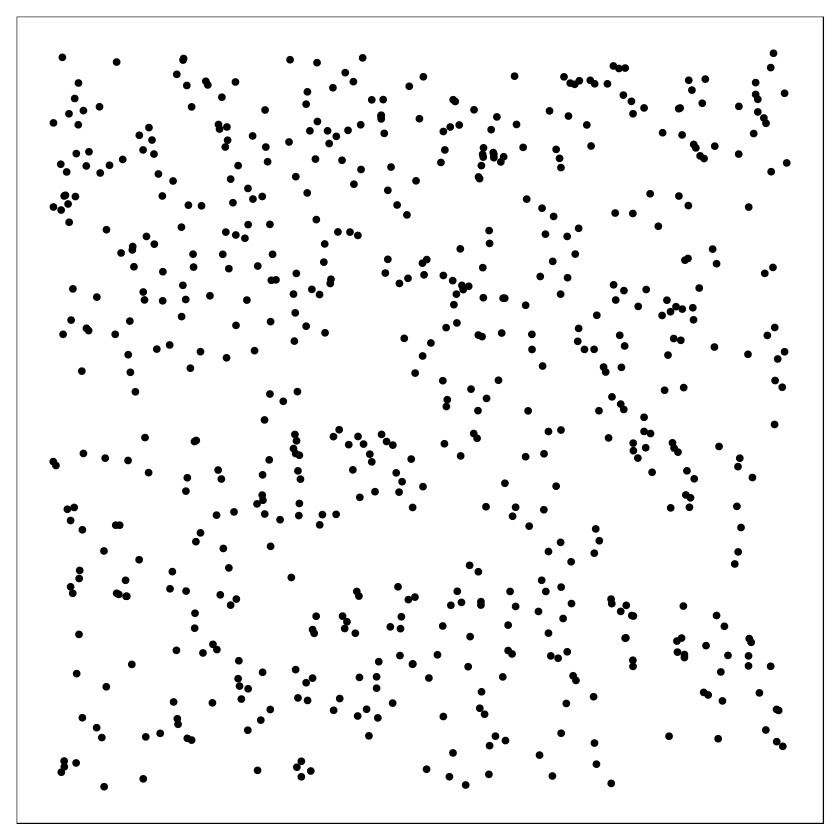

In [3]:
qplot(mini$x, mini$y)  + 
    labs(x = '', y = ' ') +
    theme_void() +
    theme(plot.margin = margin(10,10,10,10)) +
    theme(panel.border = element_rect(fill=NA)) 

Plotting the persistence diagrams for the observed point pattern and the null model suggests that in the null model, loops with a substantial life time tend to appear earlier.

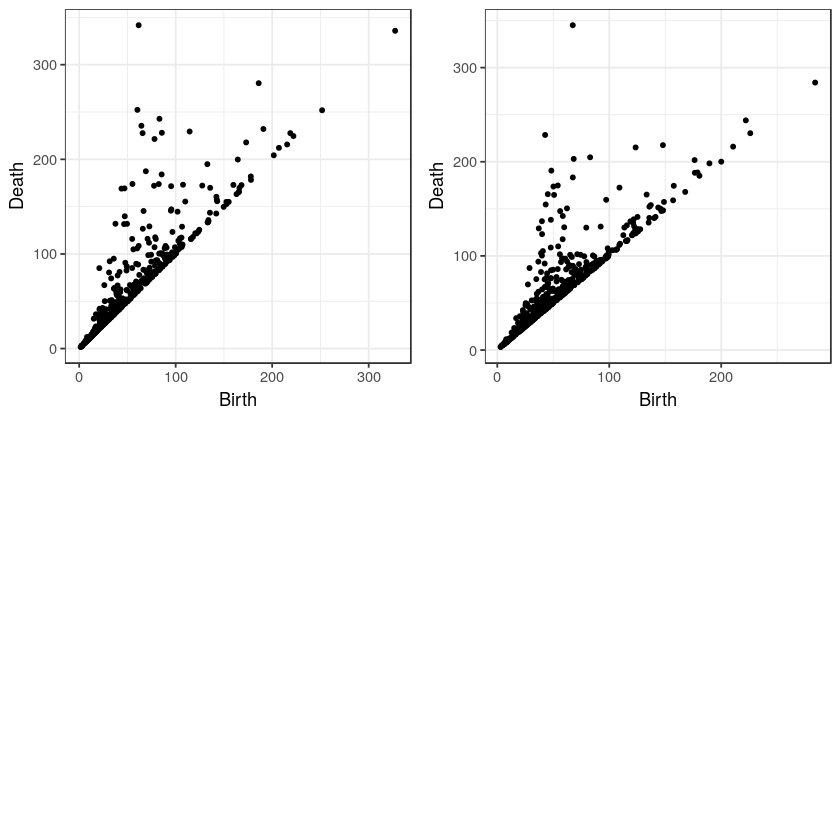

In [5]:
library(grid)
plots <- lapply(list(mini, poispps[[1]]), 
                function(pp){
                    pd <- alphaComplexDiag(cbind(pp$x, pp$y))$diag
                    lapply(0:1, 
                        function(dim) 
                            ggplot(data.frame(pd[pd[,'dimension'] == dim, 2:3]), 
                            aes(x = Birth, y = Death)) +
                            geom_point(size = 1) +
                            theme_bw()
                           )
                    })
grid.arrange( grobs = list(plots[[1]][[2]], 
                           plots[[2]][[2]]),  
             ncol = 2, nrow = 2)

Next, we import from the [simulation part](sim_ana.ipynb) the functions for computing the test statistics.

In [8]:
tx0 <- seq(0, 2.99, by = .03)
tx12 <- seq(0, 120, by = 1)
ty12 <- seq(0, 210, by = 1)

tda0_raw <- function(coords){
    #' Death times of a point pattern
    #'
    #' @param coords coordinates of point pattern
    
    diag <- alphaComplexDiag(coords)$diagram
    diag_df <-  data.frame(dimension = diag[,1], 
                           death = diag[,3])
    sort(diag_df[diag_df$dimension == 0, 'death'])  
}

tda0 <- function(X, 
                 r = 0, 
                 tx = tx0,
                 correction = NULL){
    #' Adapter of death times for spatstat scaled by number of points
    #'
    #' @param X point pattern
    #' @param r time point
    #' @param t_vals time values for which the accumulated death count is computed
    #' @param correction edge correction
    dt <- tda0_raw(cbind(X$x, X$y))
    
    #intensity 
    intens <- X$n / area.owin(mini$window)
    
    #rescale integration domain
    tx <- tx * sqrt(2 / intens)
    
    fv(data.frame(r = tx, 
                  trans = findInterval(tx, dt) / (sqrt(intens) * area.owin(mini$window))), 
       valu = 'trans',
       labl = c('r', 'lab'),
       fname='Diag')
}

tda1_raw <- function(coords,
                     max_bt = 4000){
    #' accumulated persistence function of a point pattern
    #'
    #' @param coords coordinates of point pattern
    #' @param max_bt add maximum birth time to avoid out of bound error
    
    diag <- alphaComplexDiag(coords)$diagram
    diag_df <- data.frame(dimension = diag[,1], 
                           birth = diag[,2], 
                           life = (diag[,3] - diag[,2]))
    
    #only 1-dimensional features
    diag_df <- diag_df[diag_df$dimension == 1, 2:3]
    diag_df <- diag_df[order(diag_df$birth),]
    rownames(diag_df) <- c()
    rbind(diag_df, c(max_bt, max_bt))
}

tda1 <- function(X, 
                 r = 0, 
                 tx = tx12,
                 correction = NULL){
    #' Adapter of the accumulated persistence function for spatstat
    #'
    #' @param X point pattern
    #' @param r time point
    #' @param tx times at which the APF is computed
    
    tda1_vals <- tda1_raw(cbind(X$x, X$y))
    tda1_vals <- cbind(tda1_vals[,1], cumsum(tda1_vals$life))  
    birth_locs = findInterval(tx, tda1_vals[,1])
    
    #intensity 
    intens <- X$n / area.owin(mini$window)
    
    #rescale integration domain
    tx <- tx * sqrt(2 / intens)
    
    fv(data.frame(r = tx, 
                  trans = tda1_vals[1 + birth_locs, 2] / (sqrt(intens) * area.owin(mini$window))), 
      valu = 'trans',
      labl = c('r', 'lab'),
      fname='Diag')
}

Now, we explore whether the impressions from the persistence diagrams are reflected in the summary statistics proposed in the [simulation part](./sim_ana.ipynb). As a first step, we compare the cluster deaths up to a given time point. 

In [9]:
stat_df <- function(pps, stat){
    #' Organize summary statistics in dataframe
    #'
    #' @param pps point processes for which statistics are computed
    #' @param stat summary statistics
    tda_list <- mclapply(pps,
                stat,
                mc.cores = 4
               )
    do.call('rbind', 
            lapply(tda_list, function(dt) dt$trans))
}

In [10]:
poispps_tda0_df <- stat_df(poispps, tda0)
mini_tda0 <- tda0(mini)$trans

When comparing the number of cluster death at different points in time, we note that the curve for the observed data runs a bit above the curve for the null model.

In [12]:
compare_df <- data.frame(
    t = tx0,
    ppp = colMeans(poispps_tda0_df),
    mini = mini_tda0
)

pl_1 <- ggplot(compare_df, aes(t)) +
    geom_line(aes(y = ppp, color = "a")) +
    geom_line(aes(y = mini, color = "b")) +
    scale_color_discrete(name = "Model", 
                         labels = c("Poisson", "Minicolumn")) +
    xlab('t') +
    ylab('Number of deaths') +
    theme_bw()

Next, we proceed to the loop-based features. Here, the curve for the observed pattern runs substantially below the one of the null model. This reflects a property that we have already encountered in the persistence diagram: loops with substantial life time tend to be born earlier in the null model, thereby leading to a steeper increase of the accumulated life times.

In [43]:
poispps_tda12_dfs <- stat_df(poispps, tda1)
mini_tda12 <- tda1(mini)

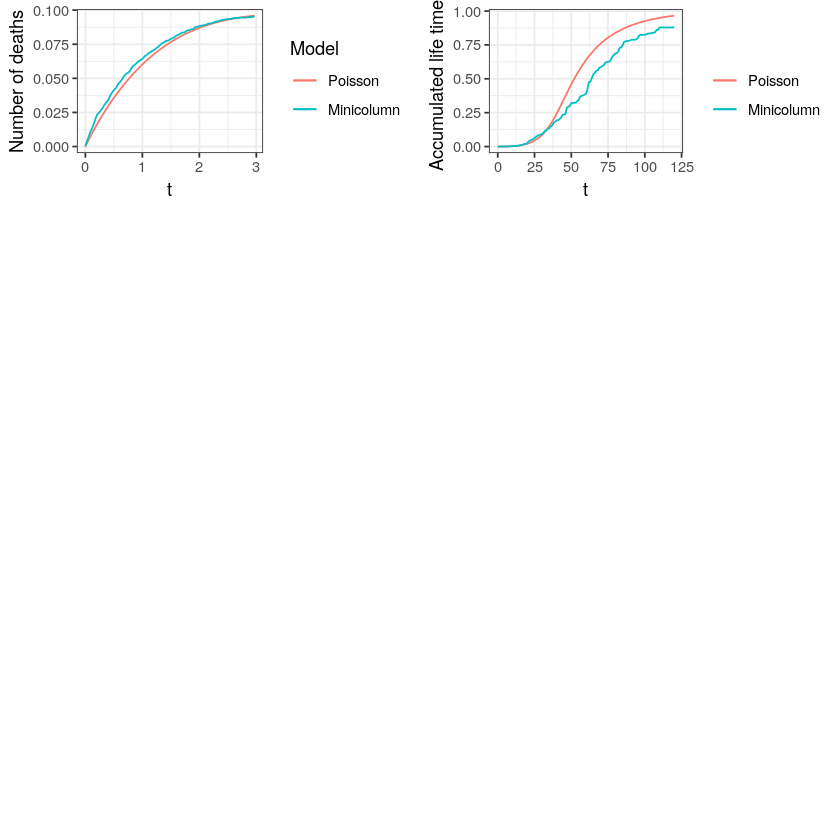

In [77]:
compare_df <- data.frame(
    t = tx12,
    ppp = colMeans(poispps_tda12_dfs),
    mini = tda1(mini)$trans
)

pl_2 <- ggplot(compare_df, aes(t)) +
    geom_line(aes(y=ppp, color="a")) +
    geom_line(aes(y=mini, color="b")) +
    scale_color_discrete(name = "", 
                         labels = c("Poisson", "Minicolumn")) +
    xlab('t') +
    ylab('Accumulated life times') +
    theme_bw()
grid.arrange(pl_1, pl_2,
             nrow = 4, ncol = 2)

## Test for complete spatial randomness

Under the impression of the previous visualizations, we now test the minicolumn pattern against the Poisson null model. As in the [simulation part](./sim_ana.ipynb), we deduce from the functional CLT that the statistics are asymptotically normal under the null hypothesis, so that we only need to determine means and variances.

A subtle issue concerns the choice of the integration interval. For the loop-based features, we simply take the entire interval $[0, 120]$. For the cluster-based features the choice of the interval is more difficult, since taking the entire interval is not discriminatory. The experiences from the simulation section indicate that the test is most powerful for small values of death times, so we choose the integration interval $[0, 1]$.

In [54]:
intervals <- list(1:35, 1:120)
stats <- list(poispps_tda0_df, poispps_tda12_dfs)

null_means <- lapply(1:2, 
                     function(i) mean(rowMeans(stats[[i]][, intervals[[i]]])))
null_sds <- lapply(1:2, 
                   function(i) sd(rowMeans(stats[[i]][, intervals[[i]]])))

With these choices, both the cluster-based and the loop-based test reject the null-hypothesis at the $5\%$-level, since the corresponding $p$-values are $0.18\%$ and $0.031\%$. 

In [55]:
p_val <- function(stat, 
                  null_mean, 
                  null_sd, 
                  interval){
    #' p-value for deviation test
    #'
    #' @param stats functional summary statistics
    #' @param null_mean mean under the null model
    #' @param null_sd standard deviation under the null model
    #' @param interval integration interval
    z_val <- abs(mean(stat[interval]) - null_mean) / null_sd
    2 * (1 - pnorm(z_val))
}

In [72]:
mini_stats <- list(mini_tda0, mini_tda12$trans)
sapply(1:2, 
       function(i) p_val(mini_stats[[i]], 
                        null_means[[i]],
                        null_sds[[i]],
                        intervals[[i]]))

[1] 0.001816971 0.003102341

However, the tests exhibit a certain sensitivity to the choice of the integration bound. On the one hand, when changing the integration domains for the cluster- and loop-based tests to $[0, 2]$ and $[0, 70]$, then the null hypothesis is still rejected with $p$-values $4.55\%$ and $1.4\%$. However, if we change the intervales to $[0, 2.5]$ and $[0, 60]$, then the $p$-value decrease to $10.7\%$ and $5.1\%$ so that the null-hypothesis is no longer rejected.

In [110]:
intervals <- list(1:85, 1:60)
stats <- list(poispps_tda0_df, poispps_tda12_dfs)

null_means <- lapply(1:2, 
                     function(i) mean(rowMeans(stats[[i]][, intervals[[i]]])))
null_sds <- lapply(1:2, 
                   function(i) sd(rowMeans(stats[[i]][, intervals[[i]]])))

In [111]:
mini_stats <- list(mini_tda0, mini_tda12$trans)
sapply(1:2, 
       function(i) p_val(mini_stats[[i]], 
                        null_means[[i]],
                        null_sds[[i]],
                        intervals[[i]]))

[1] 0.10718799 0.05085882